In [ ]:
############################################ Loading libraries and user arguments ###########################################

import os
import utils.blast_utils as blast
import pandas as pd
import matplotlib.pyplot as plt
import argparse
from Bio import SeqIO  

test = True
if test:
    print('Warning! Developer mode activated')
    input_fasta = '/home/jpereira/OEs/OE1.v2/Data/short_tandem_repeats/sequences_wo_str.fasta'
    param_min_aln_identity = 95
    param_min_aln_length = 50
    param_min_blast_word_size = 20
    param_threads = 20
    output_blast_tsv = '/home/jpereira/OEs/OE1.v2/Data/blast_abc/blastn.seqs_wo_str.inner.tsv'
    output_blast_graph_abc = '/home/jpereira/OEs/OE1.v2/Data/blast_abc/blast_map.abc'
    output_uninformative_seqs_fasta = '/home/jpereira/OEs/OE1.v2/Data/blast_abc/uninformative_sequences.fasta'
else:
    parser = argparse.ArgumentParser()
    parser.add_argument('--input-fasta')
    parser.add_argument('--param-min-aln-identity', type=float, default=95)
    parser.add_argument('--param-min-aln-length', type=int, default=50)
    parser.add_argument('--param-min-blast-word-size', type=int, default=20)
    parser.add_argument('--param-threads', type=int, default=20)
    parser.add_argument('--output-blast-table')
    parser.add_argument('--output-coverage-graph-abc')
    parser.add_argument('--output-uninformative-seqs-list')
    
    # Capture the parsed arguments in a variable (args)
    args = parser.parse_args()
    
    input_fasta = args.input_fasta
    param_min_aln_identity = args.param_min_aln_identity
    param_min_aln_length = args.param_min_aln_length
    param_min_blast_word_size = args.param_min_blast_word_size
    param_threads = args.param_threads
    output_blast_tsv = args.output_blast_table
    output_blast_graph_abc = args.output_coverage_graph_abc
    output_uninformative_seqs_fasta = args.output_uninformative_seqs_fasta


##### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Warning! Developer mode activated


In [3]:

######################################### Performing blast with the same sequences #########################################

# Make blast_db directory
db_basedir = os.path.dirname(output_blast_tsv)
db_dirname = os.path.join(db_basedir, f'decont_inner_db')

# Make blastn database
blast_db_file = blast.makeblast_db(input_fasta, db_dirname)

blast.blastn(blast_input_seqs=input_fasta, blast_db_file=blast_db_file, blast_output_table_tsv=output_blast_tsv, word_size=20, num_threads=40)

##### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

###################################### Procesisng blast table discarting uninformative alignments #############################

# Loading blastn table
blast_df_start = pd.read_csv(output_blast_tsv, sep='\t', header=None)
blast_df_start.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 
                    'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen']

# Remove alignments with the same query and subject only if it has a coverage greater than 90%
filter_seqs =  ~((blast_df_start['qseqid'] == blast_df_start['sseqid']) & (blast_df_start['length']/blast_df_start['qlen'] > 0.9 ))
blast_df = blast_df_start[filter_seqs]

# Select alignments with an pident greater than 95% and a length greather than 50 bases 
select = (blast_df['pident'] > param_min_aln_identity) & (blast_df['length'] >= param_min_aln_length)
blast_df = blast_df[select]

blast_df = blast.alignment_absolute_start_end(blast_df) 
blast_df = blast_df.sort_values(['qseqid', 'sseqid' , 'qstart'])

##### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

################################## Saving sequences coverage graph and uninformative sequences ################################

# Compute the set difference between the original and filtered BLAST results
uninformative_seqs = set(blast_df_start['qseqid']) - set(blast_df['qseqid'])

# Write the uninformative sequences to an output FASTA file
with open(input_fasta, 'r') as in_fasta, open(output_uninformative_seqs_fasta, 'w') as out_fasta:
    # Parse the FASTA file using SeqIO
    for record in SeqIO.parse(in_fasta, 'fasta'):
        if record.id in uninformative_seqs:
            out_fasta.write(f'>{record.id}\n{record.seq}\n')


# Convert coverage information from blast table to a graph in abc format
group_qs_df = blast_df.groupby(['qseqid','sseqid'])
total_coverage_qs = group_qs_df.apply(lambda x: blast.total_coverage_temp(x, use='subject')).reset_index(name='coverage_fraction')
total_coverage_qs.to_csv(output_blast_graph_abc, sep='\t', index=False)

##### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    



Building a new DB, current time: 04/11/2025 18:14:30
New DB name:   /home/jpereira/OEs/OE1.v2/Data/blast_abc/decont_inner_db/sequences_wo_str.fasta
New DB title:  /home/jpereira/OEs/OE1.v2/Data/short_tandem_repeats/sequences_wo_str.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /home/jpereira/OEs/OE1.v2/Data/blast_abc/decont_inner_db/sequences_wo_str.fasta
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 910 sequences in 0.0299821 seconds.


makeblastdb ran successfully.
Running: blastn -query /home/jpereira/OEs/OE1.v2/Data/short_tandem_repeats/sequences_wo_str.fasta -db /home/jpereira/OEs/OE1.v2/Data/blast_abc/decont_inner_db/sequences_wo_str.fasta -out /home/jpereira/OEs/OE1.v2/Data/blast_abc/blastn.seqs_wo_str.inner.tsv -num_threads 40 -gapextend 5 -gapopen 5 -penalty -5 -word_size 20 -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen'
blastn ran successfully.


/tmp/ipykernel_14971/1493040983.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_qs = group_qs_df.apply(lambda x: blast.total_coverage_temp(x, use='subject')).reset_index(name='coverage_fraction')


<Axes: >

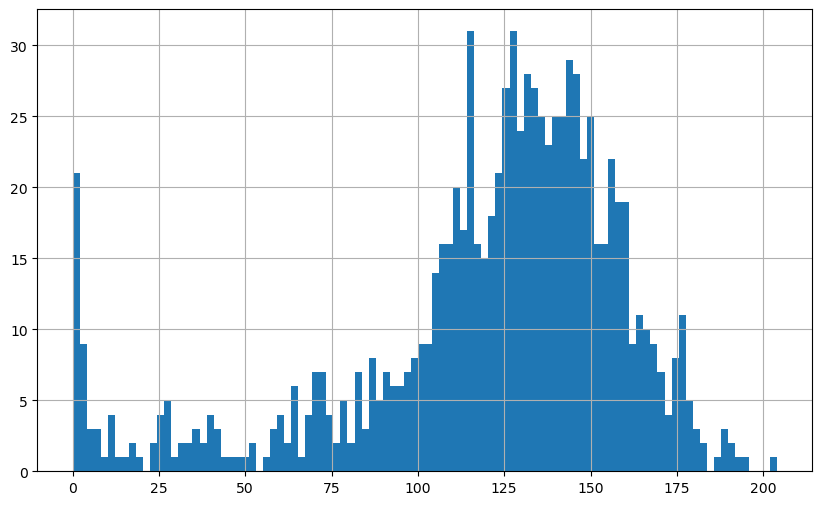

In [ ]:

# Saving the coverage between each different read
#dir_name = os.path.dirname(output_blast_graph_abc)
#os.makedirs(dir_name, exist_ok=True)
#total_coverage_qs.to_csv(output_blast_graph_abc, header=False, index=False, sep='\t')
#
#plt.figure(figsize=(10,6))
#total_coverage_qs.groupby('qseqid')['coverage_fraction'].sum().hist( bins=100)

##### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [ ]:
# Group by 'qseqid' and apply the coverage function with the 'query' parameter
#blast_df = blast_df.sort_values('a.qstart')
#group_q_df = blast_df.groupby(['qseqid'])
#total_coverage_q = group_q_df.apply(lambda x: total_coverage_temp(x, use='query')).reset_index(name='coverage_fraction')
#
## Group by 'sseqid' and apply the coverage function with the 'subject' parameter
#blast_df = blast_df.sort_values('a.sstart')
#group_s_df = blast_df.groupby(['sseqid'])
#total_coverage_s = group_s_df.apply(lambda x: total_coverage_temp(x, use='subject')).reset_index(name='coverage_fraction')

# Group by 'qseqid' 'sseqid' and apply the coverage function with the 'subject' parameter
group_qs_df = blast_df.groupby(['qseqid','sseqid'])
total_coverage_qs = group_qs_df.apply(lambda x: blast.total_coverage_temp(x, use='subject')).reset_index(name='coverage_fraction')